# Airbender Tutorial 1: Iris Flower Classification

Now that we have a good understanding of airbender's structure, let's consider an example with the Iris flower dataset. The dataset includes four features, listed below, and three classes we will try to predict. The goal is to build a model that can effectively determine the breed of the flower using only the length and width metrics provided in the feature set. 

```
Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information (Features):
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
    :class (type of flower):
        - Setosa
        - Versicolour
        - Virginica
```

## Imports

Before we start, let's import Pandas and Airbender's `DagLayer` class so we can validate our configurations.

In [1]:
import pandas as pd
import os
import sys
sys.path.append("../../")

#Import DagLayer from airbender
from airbender.dag.layers import DagLayer

## Data Sources
---------------------------------------------

Since this implementation is small and fairly simple, all we need to do is import a single dataset. Airbender has provided a link to the dataset below. To incorporate data into the experiment, we only need to write the following:

In [2]:
data_sources = {'iris':         #Tag
   DagLayer(
            {
             'https://raw.githubusercontent.com/SamShowalter/WMP_training/master/airbender_iris_demo.csv': \
             {pd.read_csv: {'sep': ','}},
            }
           )
               }

## Exploratory Data Analysis

For this dataset there are only two things that we need to look for, missing data and outliers. We will look for both of those below, but first, let's just take a peek at the dataset

In [3]:
#Peek at dataset
df = pd.read_csv('https://raw.githubusercontent.com/SamShowalter/WMP_training/master/airbender_iris_demo.csv')

#Print head
df.head()

,sepal_length,sepal_width,petal_length,petal_width,flower_label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Everything here looks fairly straightforward, so now let's take a look to see if there is missing data.

In [4]:
df.isnull().sum()

sepal_length    1
sepal_width     0
petal_length    4
petal_width     1
flower_label    0
dtype: int64

It looks like all but one feature has missing data. We will need to clean that up before modeling. Finally, let's use univariate plots to look for outliers.

In [5]:
#Viz imports
import seaborn as sns
import matplotlib.pyplot as plt


#Provided univariate plot function
def univariate_plots(data, columns):
    
    #Drop N/A values
    data = data.dropna()

    #For each numeric columns
    for col in columns:
        x = data[col]
        plt.figure(col)
        plt.figure(figsize = (20,10))
        
        #Attempt to create a univariate plot
        try:
            ax = sns.kdeplot(x, shade=True, color="r").set_title(col)
            ax = sns.distplot(x)
        
        #If there is an error, print out what happened
        except Exception as e:
            print("Didn't work for varaible: {}, {}".format(col, e))

<Figure size 432x288 with 0 Axes>

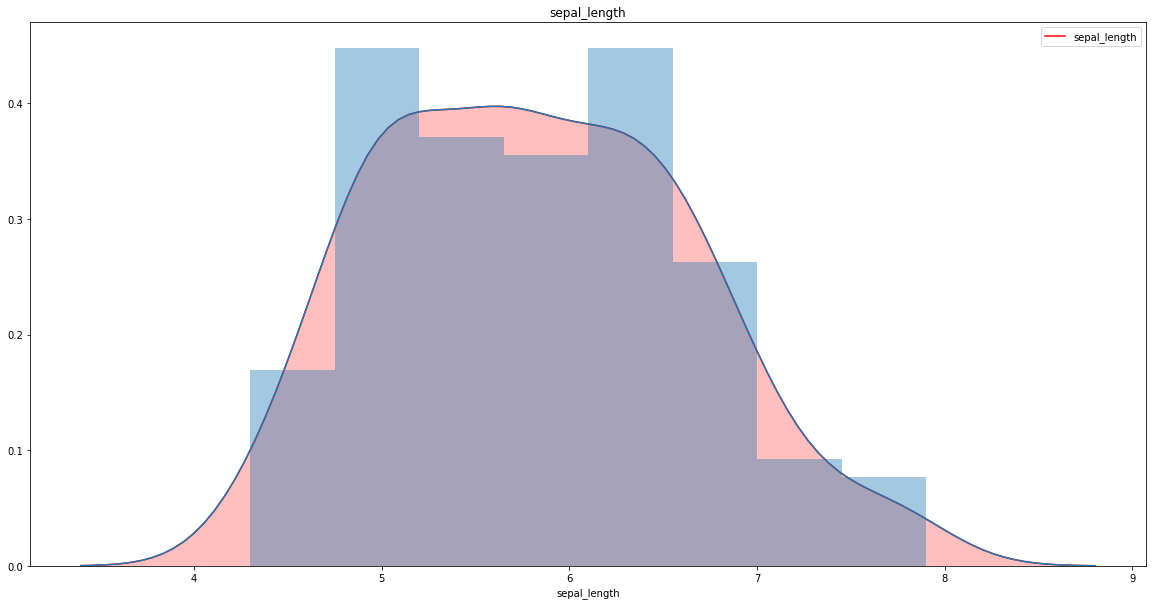

<Figure size 432x288 with 0 Axes>

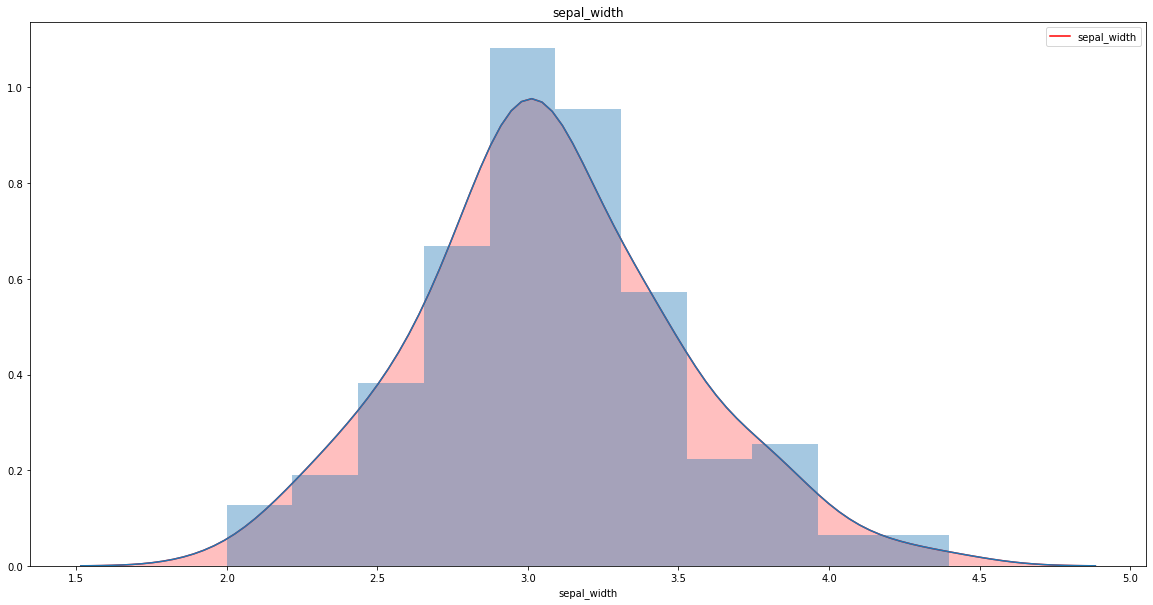

<Figure size 432x288 with 0 Axes>

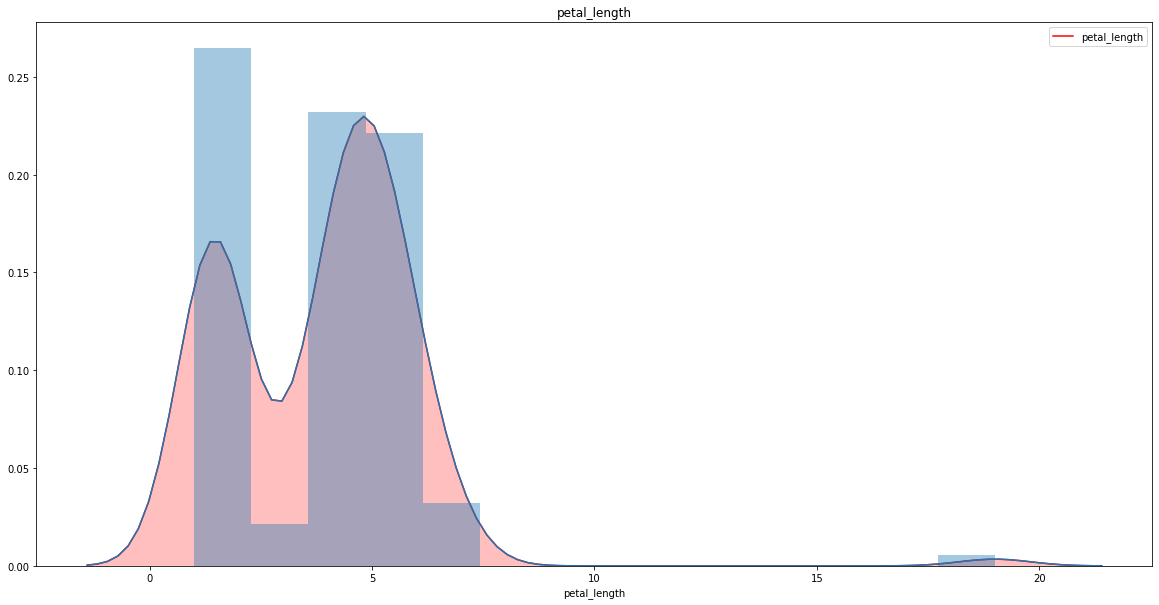

<Figure size 432x288 with 0 Axes>

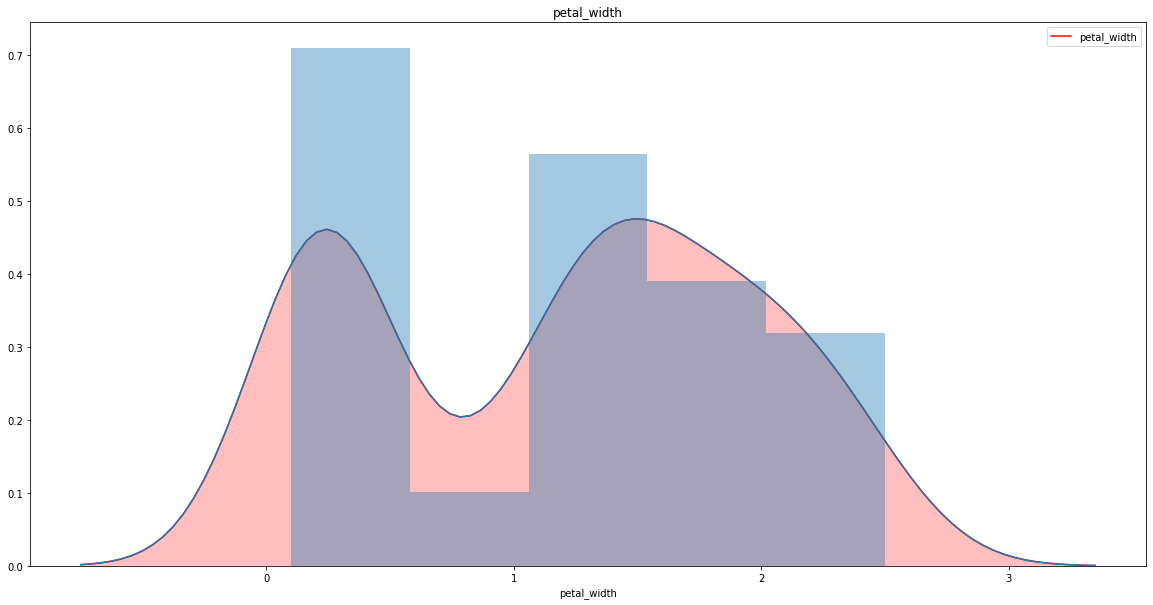

In [6]:
#Run analysis for all features
univariate_plots(df, [name for name in df.columns if name != 'flower_label'])

It looks like all of our features have a fairly reasonable distribution **except** petal length, which looks to have an outlier around 20. We will need to handle that in our modeling later.

## Splitting Data
---------------------------------------------

One of the largest benefits of Airbender is the control it offers to ensure unbiased experimentation. Right after the data is read into Airbender, it is split into `train` and `test` datasets. For every `preprocessing` and `feature_engineering` operation, the train dataset is operated on first. If the operation has any artifacts (e.g. median imputation takes the median of the training dataset as its imputation value), those values **are passed to the testing dataset operators and applied directly**. In this way, the experiment is much more likely to be free of information leak.

Right now, Airbender only accommodates traditional train test splits with a single test slice. K-fold cross validation is coming as a new feature shortly, as is the ability to select a validation slice of data.

For our Iris example, we will take a random, 25% slice of the data for our testing set. The configuration is outlined below.

In [7]:
#Import splitting functionality
from airbender.static.splitting import train_test_split

splitting = {'split':

                    DagLayer({'sklearn': {train_test_split: {"target": "flower_label",
                                                            "test_ratio": 0.25,
                                                            "random_state": 42}
                                         }
                            })
            }

## Preprocessing
---------------------------------------------

In this edited dataset, we can see that there are some missing values. The original Iris dataset did not have missing values, but we have added them artificially to better simulate an actual dataset. 

To accommodate these missing values, we will use median imputation, provided by airbender. We need to use Airbender's label encoder function as label_encoder's ensure we attribute the same numeric label for each class across the train and test datasets. 

In [8]:
#Imports
from airbender.static.preprocessing import impute

preprocessing = {'missing_data':

                            DagLayer({
                                        # tag name             # Operator Family
                                        'median_impute':       {impute: {'method': 'median'}}
                                    })
                }


## Feature Engineering
---------------------------------------------

Feature engineering is the DagLayer where you can apply functions or series of function to specific data columns. You can also pass through columns that are already in a suitable modeling format by simply putting `None` in place of the operator and parameters dictionary.

Based on our EDA, we noticed that `petal_length` appears to have one or more outliers. We will handle those by winsorizing them with 5%-95% bounds, then normalize the data. To demonstrate how to simply pass columns through to modeling, we will assume `sepal_length` and `petal_width` do not require feature engineering. 

Lastly, we will need to encode `flower_label`.

In [9]:
#Feature Engineering Imports
from airbender.static.feature_engineering import normalize_values, winsorize, encode_labels

feature_engineering = {'col_transformations':

                            DagLayer({
                                        # Column name             # Operator Family

                                        'sepal_width':            {normalize_values: None},
                                        'sepal_length':           None,
                                        'petal_length':           {winsorize:            {'limits': [0.05, 0.05]},
                                                                   normalize_values:     None},
                                        #Pass-through
                                        'petal_width':            None,
                                        'flower_label':           {encode_labels: None}
                                    })
                      }

## Modeling
---------------------------------------------

The modeling sublayer currently follows a `fit` and `predict` interface, meaning all `scikit-learn` models and many additional algorithms like `lightgbm` and `xgboost` are compatible. Deep learning models are not yet compatible. Airbender currently only supports supervised algorithms as well. You do not need to instantiate the models you provide. Airbender will do this for you.

For the Iris dataset, we will examine three models, all from `scikit-learn`: Random Forest, Support Vector Machine, and Logistic Regression. The configuration for this is shown below.

In [10]:
#Import models from Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

modeling = {'modeling': 
                
                DagLayer({
                            'LOG': {LogisticRegression:         {'solver':'lbfgs'}},           
                            'RF':  {RandomForestClassifier:     {'n_estimators': 10}},
                            'SVM': {SVC:                        {'kernel': 'linear'}}
                        })  
           }

## Evaluation
---------------------------------------------

Lastly, we need a way to determine which model is best suited to predict on this dataset. Therefore, we will provide our Airbender evaluation DagLayer with performance metrics.

In [11]:
#Import evaluation metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

evaluation = {'metrics':
                    
                     DagLayer({
                                'acc':            {accuracy_score: None},
                                'recall':         {precision_score: {'average': 'weighted'}},
                                'precision':      {recall_score: {'average': 'weighted'}},
                                'f1':             {f1_score: {'average': 'weighted'}}
                             })
             }

## Consolidate all Configurations
---------------------------------------------

Now that we have all of the functionality we need to run an experiment with the Iris dataset, we need to consolidate that into a single configuration object. This is typically done with the following structure. Note, you can write these steps in any order, as the conceptual DAG configuration will ensure correct order (e.g. `data_sources` is first, `evaluation` last).

In [12]:
iris_config = {
                'data_sources':            data_sources,
                'splitting':               splitting,
                'preprocessing':           preprocessing,
                'feature_engineering':     feature_engineering,
                'modeling':                modeling,
                'evaluation':              evaluation
              }

Almost done! We need to add a few final arguments to label our experiment and send the correct metadata to developers and users. First, we need to give the experiment a `dag_name`, shown below. The `dag` argument is a list of the parameters the user wants to pass directly to airflow about the management of its execution. More information about this section can be found in the Airflow documentation [here]().

In [13]:
airbender_config = { 
                        'dag_name': "Airbender_Iris_Tutorial",
                        
                        'dag':      {
                                        'owner': 'airbender',
                                        # 'email': [<EMAIL>, <EMAIL>, ...],
                                        # 'op_args':{},
                                        # 'op_kwargs': {},
                                    },
                                    
                        #DAG configuration we just created
                        'config' : iris_config
                   }

All finished! Now we are ready to generate the code for our Airbender DAG.

## Generate Airbender DAG
---------------------------------------------

Once we have written a valid Airbender configuration, generating the code for the DAG is incredibly simple. All you need to do is give the configuration to Airbender's DAG generator, shown below.

In [14]:
#DAG Generator Imports
from airbender.dag.generator import DagGenerator

#Generate File
dg = DagGenerator(airbender_config)
dg.generate_file()


Displaying Ordered Dag Layers with Tags:

0 ['data_sources', 'iris']
1 ['splitting', 'split']
2 ['preprocessing', 'missing_data']
3 ['feature_engineering', 'col_transformations']
4 ['modeling', 'modeling']
5 ['evaluation', 'metrics']

Generated airflow file with name: Airbender_Iris_Tutorial_airbender_10-28-2019--15.26.01.py


Now our experiment has been converted into a DAG that is ready to run on Airflow. Note that Airbender intelligently imported all of the functions and classes we used in our configuration into the final file. You can view the file we just generated [here](<LINK TO OUTPUT FILE>). 

## View and Run DAG in Airflow
--------------------------------------------

At this point, our job is finished. All we need to do is place this file into our airflow dag directory, turn on Airflow's scheduler and webserver, and watch the experiment run. While the experiment is running, you can track the progress of the DAG in real-time by with Airflow's tree or graph view, shown below.

**Generated Airbender DAG**
<img src="https://i.ibb.co/dfkLgTg/iris-dag.jpg" alt="iris-dag" border="0">
    
You can also analyze the content, input, output, and metadata of specific tasks by clicking on them and viewing the Airflow log. Airbender wraps all of your functions in decorators to ensure compatibility, but the task id will indicate which functions were run. If more information is needed, you may find it in the `params` log after clicking on a specific task instance, shown below.

**Airbender Task Viewer in Airflow**
<img src="https://i.ibb.co/4W7sB0z/iris-dag-task.jpg" alt="iris-dag-task" border="0">
